## Stimulus, PRF, and BOLD prediction

The retinotopic-mapping videos are transformed to `(time, y, x)` numpy arrays. The PRF are arrays of the same shape, although they are constant across time. The predicted BOLD response for a given PRF is the stimulus video multiplied by the PRF, and then convolved with the HRF.

In [1]:
from matplotlib import pyplot as plt
from forrestprf import stimulus, predictions

stim64 = stimulus.retinotopic_mapping_stim(64)
plt.figure(figsize=(8, 8))
plt.subplot(221)
plt.title('One stimulus frame downsampled 64×')
plt.imshow(stim64[2])
plt.subplot(222)
plt.title('An example PRF')
plt.imshow(predictions.prf(4, 12, .5, stim64.shape)[0])
plt.subplot2grid((2, 2), (1, 0), colspan=2)
plt.title('Predicted bold response for example PRF')
plt.plot(
    predictions.bold_prediction(4, 12, .5, stim64, hrf=False),
    color='green', label='Without HRF'
)
plt.plot(
    predictions.bold_prediction(4, 12, .5, stim64, hrf=True),
    color='red', label='With HRF'
)
plt.legend()
plt.show()

Processing inputs/studyforrest-data-phase2/stimuli/retinotopic_mapping/wedge_clock.mkv
Processing inputs/studyforrest-data-phase2/stimuli/retinotopic_mapping/wedge_counter.mkv
Processing inputs/studyforrest-data-phase2/stimuli/retinotopic_mapping/ring_contract.mkv
Processing inputs/studyforrest-data-phase2/stimuli/retinotopic_mapping/ring_expand.mkv


<Figure size 800x800 with 3 Axes>

## PRF mapping for V1

Load the retinotopic-mapping stimulus, the subject data, and a mask for the occipital cortex.

In [2]:
from forrestprf import data, stimulus

print('Load stimulus')
stim = stimulus.retinotopic_mapping_stim(4)
print('Load subject data')
bold = data.subject_data(1)
print('Load subject mask')
mask = data.juelich_mask(data.ROI_JUELICH['V1'])

Load stimulus
Load subject data
Load subject mask


Then we perform the actual PRF mapping. This will take some time!

In [3]:
from forrestprf import fitting

pass1 = fitting.prf_map(stim, bold, mask, npass=1)
pass2 = fitting.prf_map(stim, bold, mask, npass=2)
pass3 = fitting.prf_map(stim, bold, mask, npass=3)
pass4 = fitting.prf_map(stim, bold, mask, npass=4)

PRF mapping (pass 1)
PRF mapping (pass 1)
PRF mapping (pass 2)
PRF mapping (pass 1)
PRF mapping (pass 2)
PRF mapping (pass 3)
PRF mapping (pass 1)
PRF mapping (pass 2)
PRF mapping (pass 3)
PRF mapping (pass 4)


Look at how the error changes with different passes of the mapping. From pass 2 to 3 the error actually increases as a result of reduced downsampling of the bold signal.

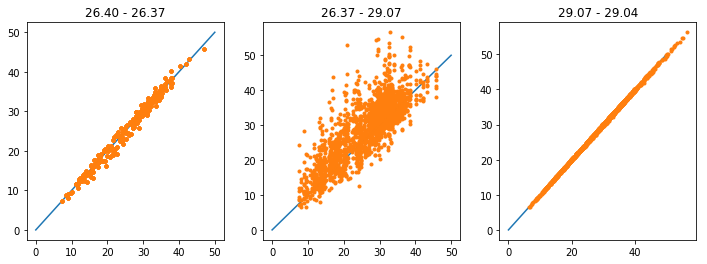

In [11]:
import numpy as np

x1, y1, sd1, err1 = pass1.params
x2, y2, sd2, err2 = pass2.params
x3, y3, sd3, err3 = pass3.params
x4, y4, sd4, err4 = pass4.params

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title('{:.2f} - {:.2f}'.format(np.nanmean(err1), np.nanmean(err2)))
plt.plot( (0, 50), (0, 50) )
plt.plot(err1, err2, '.')
plt.subplot(1, 3, 2)
plt.title('{:.2f} - {:.2f}'.format(np.nanmean(err2), np.nanmean(err3)))
plt.plot( (0, 50), (0, 50) )
plt.plot(err2, err3, '.')
plt.subplot(1, 3, 3)
plt.title('{:.2f} - {:.2f}'.format(np.nanmean(err3), np.nanmean(err4)))
plt.plot( (0, 50), (0, 50) )
plt.plot(err3, err4, '.')

Visually inspect some good fitting bold traces.

26 6 22


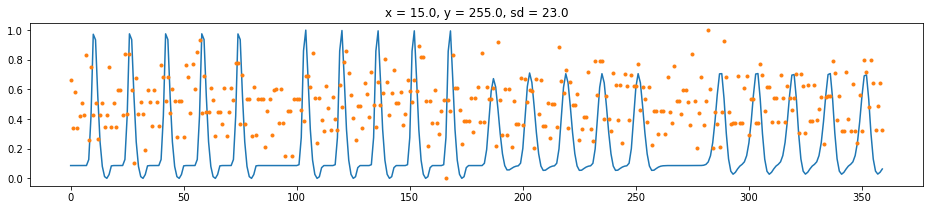

29 6 23


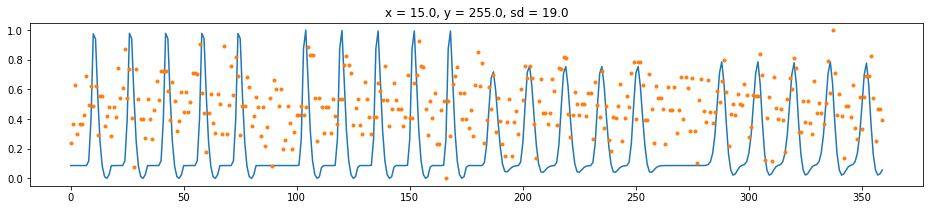

29 7 23


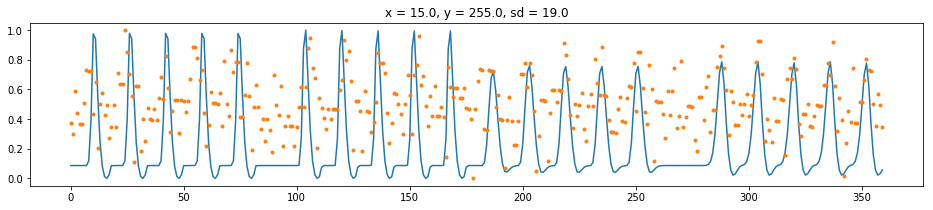

29 9 21


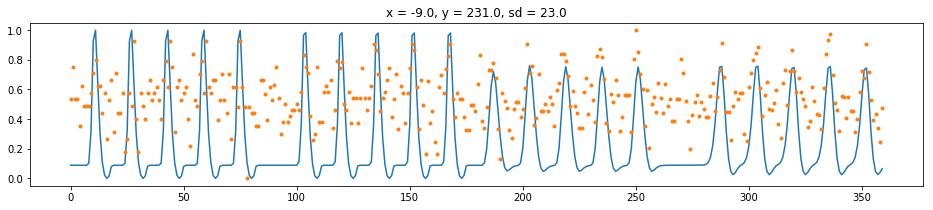

29 19 28


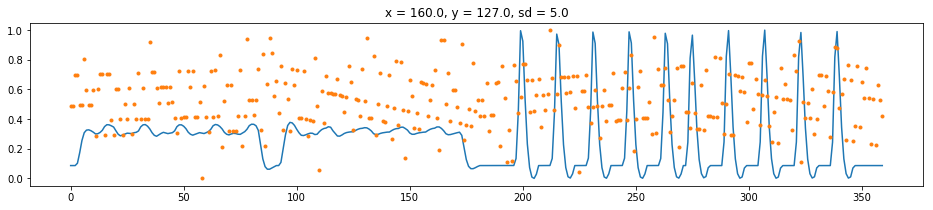

30 10 21


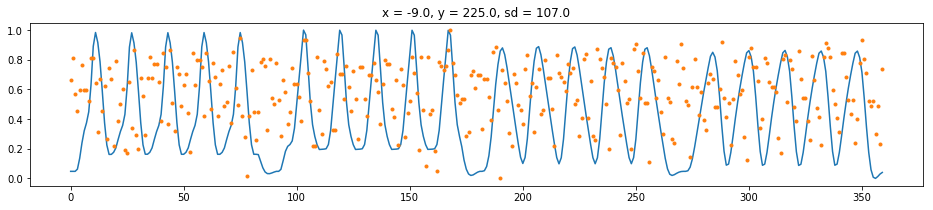

31 8 26


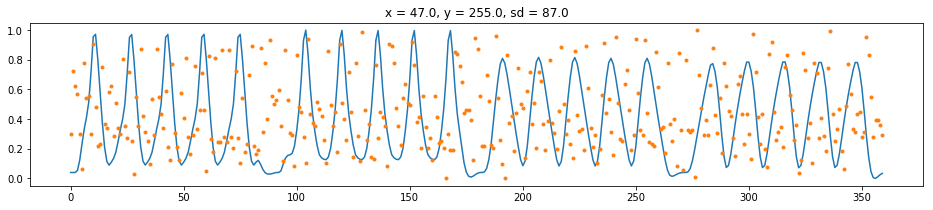

31 9 26


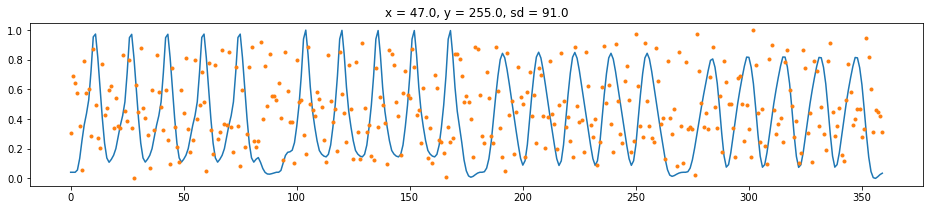

40 6 18


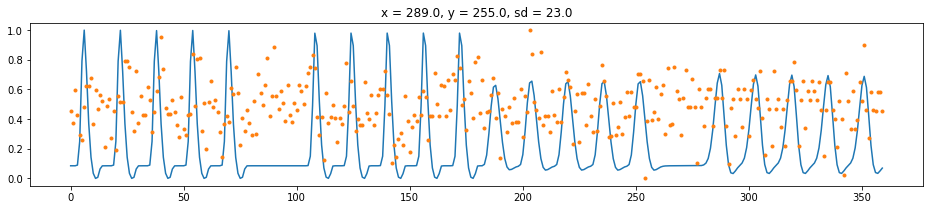

40 6 19


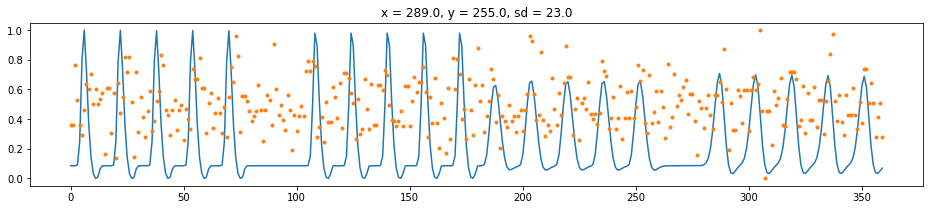

41 4 20


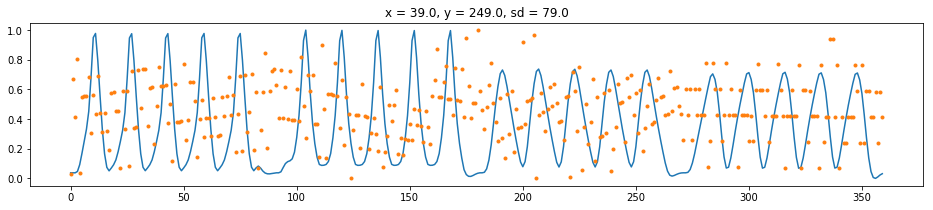

41 6 17


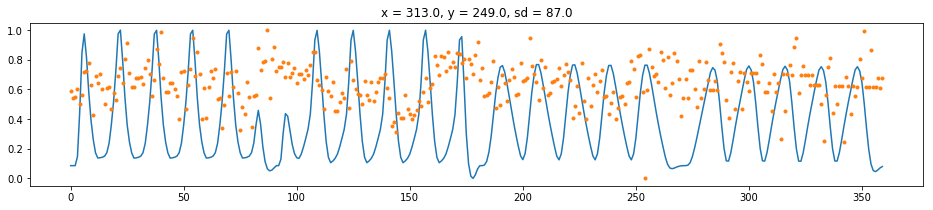

41 6 18


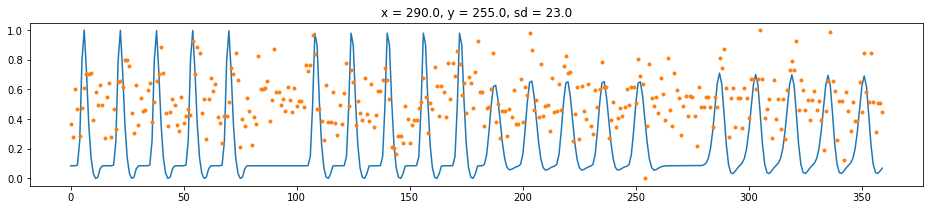

In [16]:
passx = pass4
stimx = stim
for x, y, z in zip(*np.where(passx.err > 50)):
    print(x, y, z)
    prfx, prfy, prfsd, prferr = passx[x, y, z]
    vox = bold.get_data()[x, y, z].copy()
    vox -= vox.min()
    vox /= vox.max()    
    pred = predictions.bold_prediction(prfx, prfy, prfsd, stimx)
    plt.figure(figsize=(16, 3))
    plt.title('x = {}, y = {}, sd = {}'.format(prfx, prfy, prfsd))
    plt.plot(pred)
    plt.plot(vox, '.')
    plt.show()


Plot the actual receptive fields.

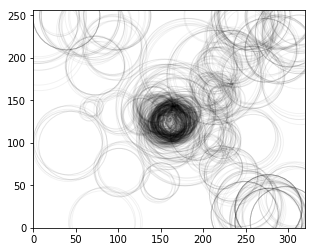

In [22]:
import seaborn as sns

for passx in (pass4, ):
    x, y, sd, err = passx.params
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal')
    for x, y, sd in zip(x, y, sd):
        if sd > 115 or x < 5 or x > 315 or y < 5 or y > 251:
            continue
        ax.add_artist(
            plt.Circle(
                xy=(x, y),
                radius=sd/2,
                alpha=.05,
                fill=False
            )
        )
    plt.xlim(0, 320)
    plt.ylim(0, 256)
    plt.show()


X - Y


/home/sebastiaan/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


X - SD
Y - SD


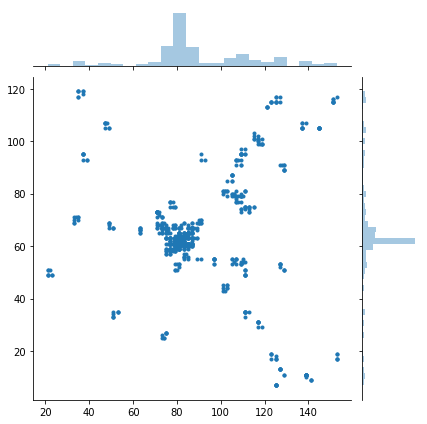

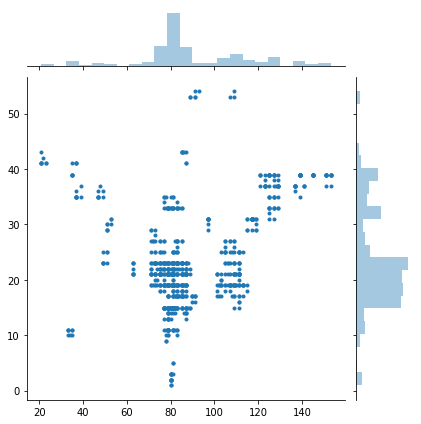

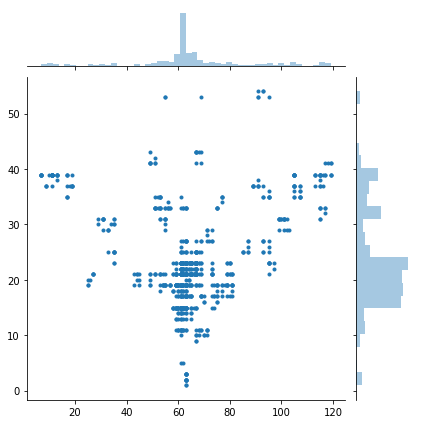

In [7]:
i = np.where((passx.sd < 55) & (passx.x < 155) & (passx.y < 123) & (passx.x > 5) & (passx.y > 5))
x = passx.x[i]
y = passx.y[i]
sd = passx.sd[i]
print('X - Y')
sns.jointplot(x, y, marker='.')
print('X - SD')
sns.jointplot(x, sd, marker='.')
print('Y - SD')
sns.jointplot(y, sd, marker='.')


# Average RF sizes for V1 - V5

PRF mapping (pass 1)
PRF mapping (pass 2)
PRF mapping (pass 3)
PRF mapping (pass 1)
PRF mapping (pass 2)
PRF mapping (pass 3)
PRF mapping (pass 1)
PRF mapping (pass 2)
PRF mapping (pass 3)
PRF mapping (pass 1)
PRF mapping (pass 2)
PRF mapping (pass 3)
PRF mapping (pass 1)
PRF mapping (pass 2)
PRF mapping (pass 3)


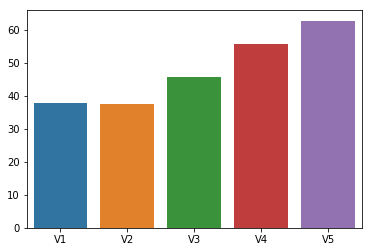

In [8]:
from datamatrix import DataMatrix
dm = DataMatrix(length=len(data.ROI_JUELICH))
dm.roi = -1
dm.rf_size = -1

for row, roi in zip(dm, data.ROI_JUELICH.keys()):
    pm = fitting.prf_map(
        stim,
        bold,
        data.juelich_mask(data.ROI_JUELICH[roi]),
        npass=3
    )
    row.roi = roi
    row.rf_size = np.nanmean(pm.sd)
sns.barplot(x='roi', y='rf_size', data=dm)